# 01 - Intro to SDK - Patients

## Setup

In [1]:
# Import pandas for data frame operations
import pandas as pd
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_colwidth", 100)
pd.set_option("display.max_rows", 100)

# Import visualization library
import matplotlib.pyplot as plt

In [2]:
# Update to current SDK version (Recommended not required)
!pip install "phc>=0.18.1"

# Import easy modules (underlying modules available in phc.services)
import phc.easy as phc

/opt/conda/lib/python3.8/site-packages/phc/easy/util.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Authentication

In [3]:
# Authentication is automatically handled in the notebooks environment.
# A shared auth object is shared across all of the phc.easy modules but
# can be customized using `auth_args`.

auth = phc.Auth.shared()

## Projects

In [4]:
# Set current project (using fuzzy search on id, name, or description)
phc.Project.set_current("BRCA")

,id,name,genomeBuild,auditLogging,versioning,lrn,account,owner,part11,description,deletionDate,shortName
68,34c0fb25-bbde-4eb1-87ed-dd4c7a1ac013,BRCA Research,GRCh38,False,False,lrn:lo:us:demo:project:34c0fb25-bbde-4eb1-87ed-dd4c7a1ac013,demo,NaN,NaN,"TCGA BRCA dataset of 1,097 breast cancer patients with publicly available omic (somatic exome an...",NaN,NaN


In [5]:
# Shared auth now contains that project_id
auth.project_id

'34c0fb25-bbde-4eb1-87ed-dd4c7a1ac013'

## Patients

In [6]:
# TIP: Use SHIFT-TAB in JupyterLab to view docs for the current function
print(phc.Patient.get_data_frame.__doc__)

Retrieve records

        Attributes
        ----------
        all_results : bool = False
            Retrieve sample of results (10) or entire set of records

        raw : bool = False
            If raw, then values will not be expanded (useful for manual
            inspection if something goes wrong)

        page_size : int
            The number of records to fetch per page

        max_pages : int
            The number of pages to retrieve (useful if working with tons of records)

        query_overrides : dict = {}
            Override any part of the elasticsearch FHIR query

        auth_args : Any
            The authenication to use for the account and project (defaults to shared)

        ignore_cache : bool = False
            Bypass the caching system that auto-saves results to a CSV file.
            Caching only occurs when all results are being retrieved.

        expand_args : Any
            Additional arguments passed to phc.Frame.expand

        log : bool = Fa

In [7]:
phc.Patient.get_data_frame(raw=True, page_size=1).iloc[0].to_dict()

Retrieved 1/1098 results


{'id': '0045349c-69d9-4306-a403-c9c1fa836644',
 'name': [{'text': 'A1A0SB LO', 'given': ['A1A0SB'], 'family': 'LO'}],
 'extension': [{'url': 'http://hl7.org/fhir/StructureDefinition/us-core-race',
   'valueCodeableConcept': {'text': 'race',
    'coding': [{'code': '2106-3',
      'system': 'http://hl7.org/fhir/v3/Race',
      'display': 'white'}]}},
  {'url': 'http://hl7.org/fhir/StructureDefinition/us-core-ethnicity',
   'valueCodeableConcept': {'text': 'ethnicity',
    'coding': [{'code': '2186-5',
      'system': 'http://hl7.org/fhir/v3/Ethnicity',
      'display': 'not hispanic or latino'}]}}],
 'resourceType': 'Patient',
 'gender': 'female',
 'birthDate': '1937-04-10',
 'deceasedBoolean': False,
 'identifier': [{'type': {'coding': [{'code': 'ANON',
      'system': 'http://hl7.org/fhir/v2/0203'}]},
   'value': 'LO-A1-A0SB'}],
 'meta': {'tag': [{'system': 'http://lifeomic.com/fhir/dataset',
    'code': '34c0fb25-bbde-4eb1-87ed-dd4c7a1ac013'}],
  'lastUpdated': '2020-06-18T17:30:56.6

In [8]:
# Get all patient results (by scrolling through all pages)
patient_df = phc.Patient.get_data_frame(all_results=True)

patient_df.info()

[CACHE] Loading from "/home/jovyan/Downloads/phc/api-cache/fhir_dsl_patient_f94f37d0.csv"
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1098 entries, 0 to 1097
Data columns (total 32 columns):
 #   Column                                                                                                                                     Non-Null Count  Dtype              
---  ------                                                                                                                                     --------------  -----              
 0   id                                                                                                                                         1098 non-null   object             
 1   name_given_0                                                                                                                               1098 non-null   object             
 2   name_family                                                                   

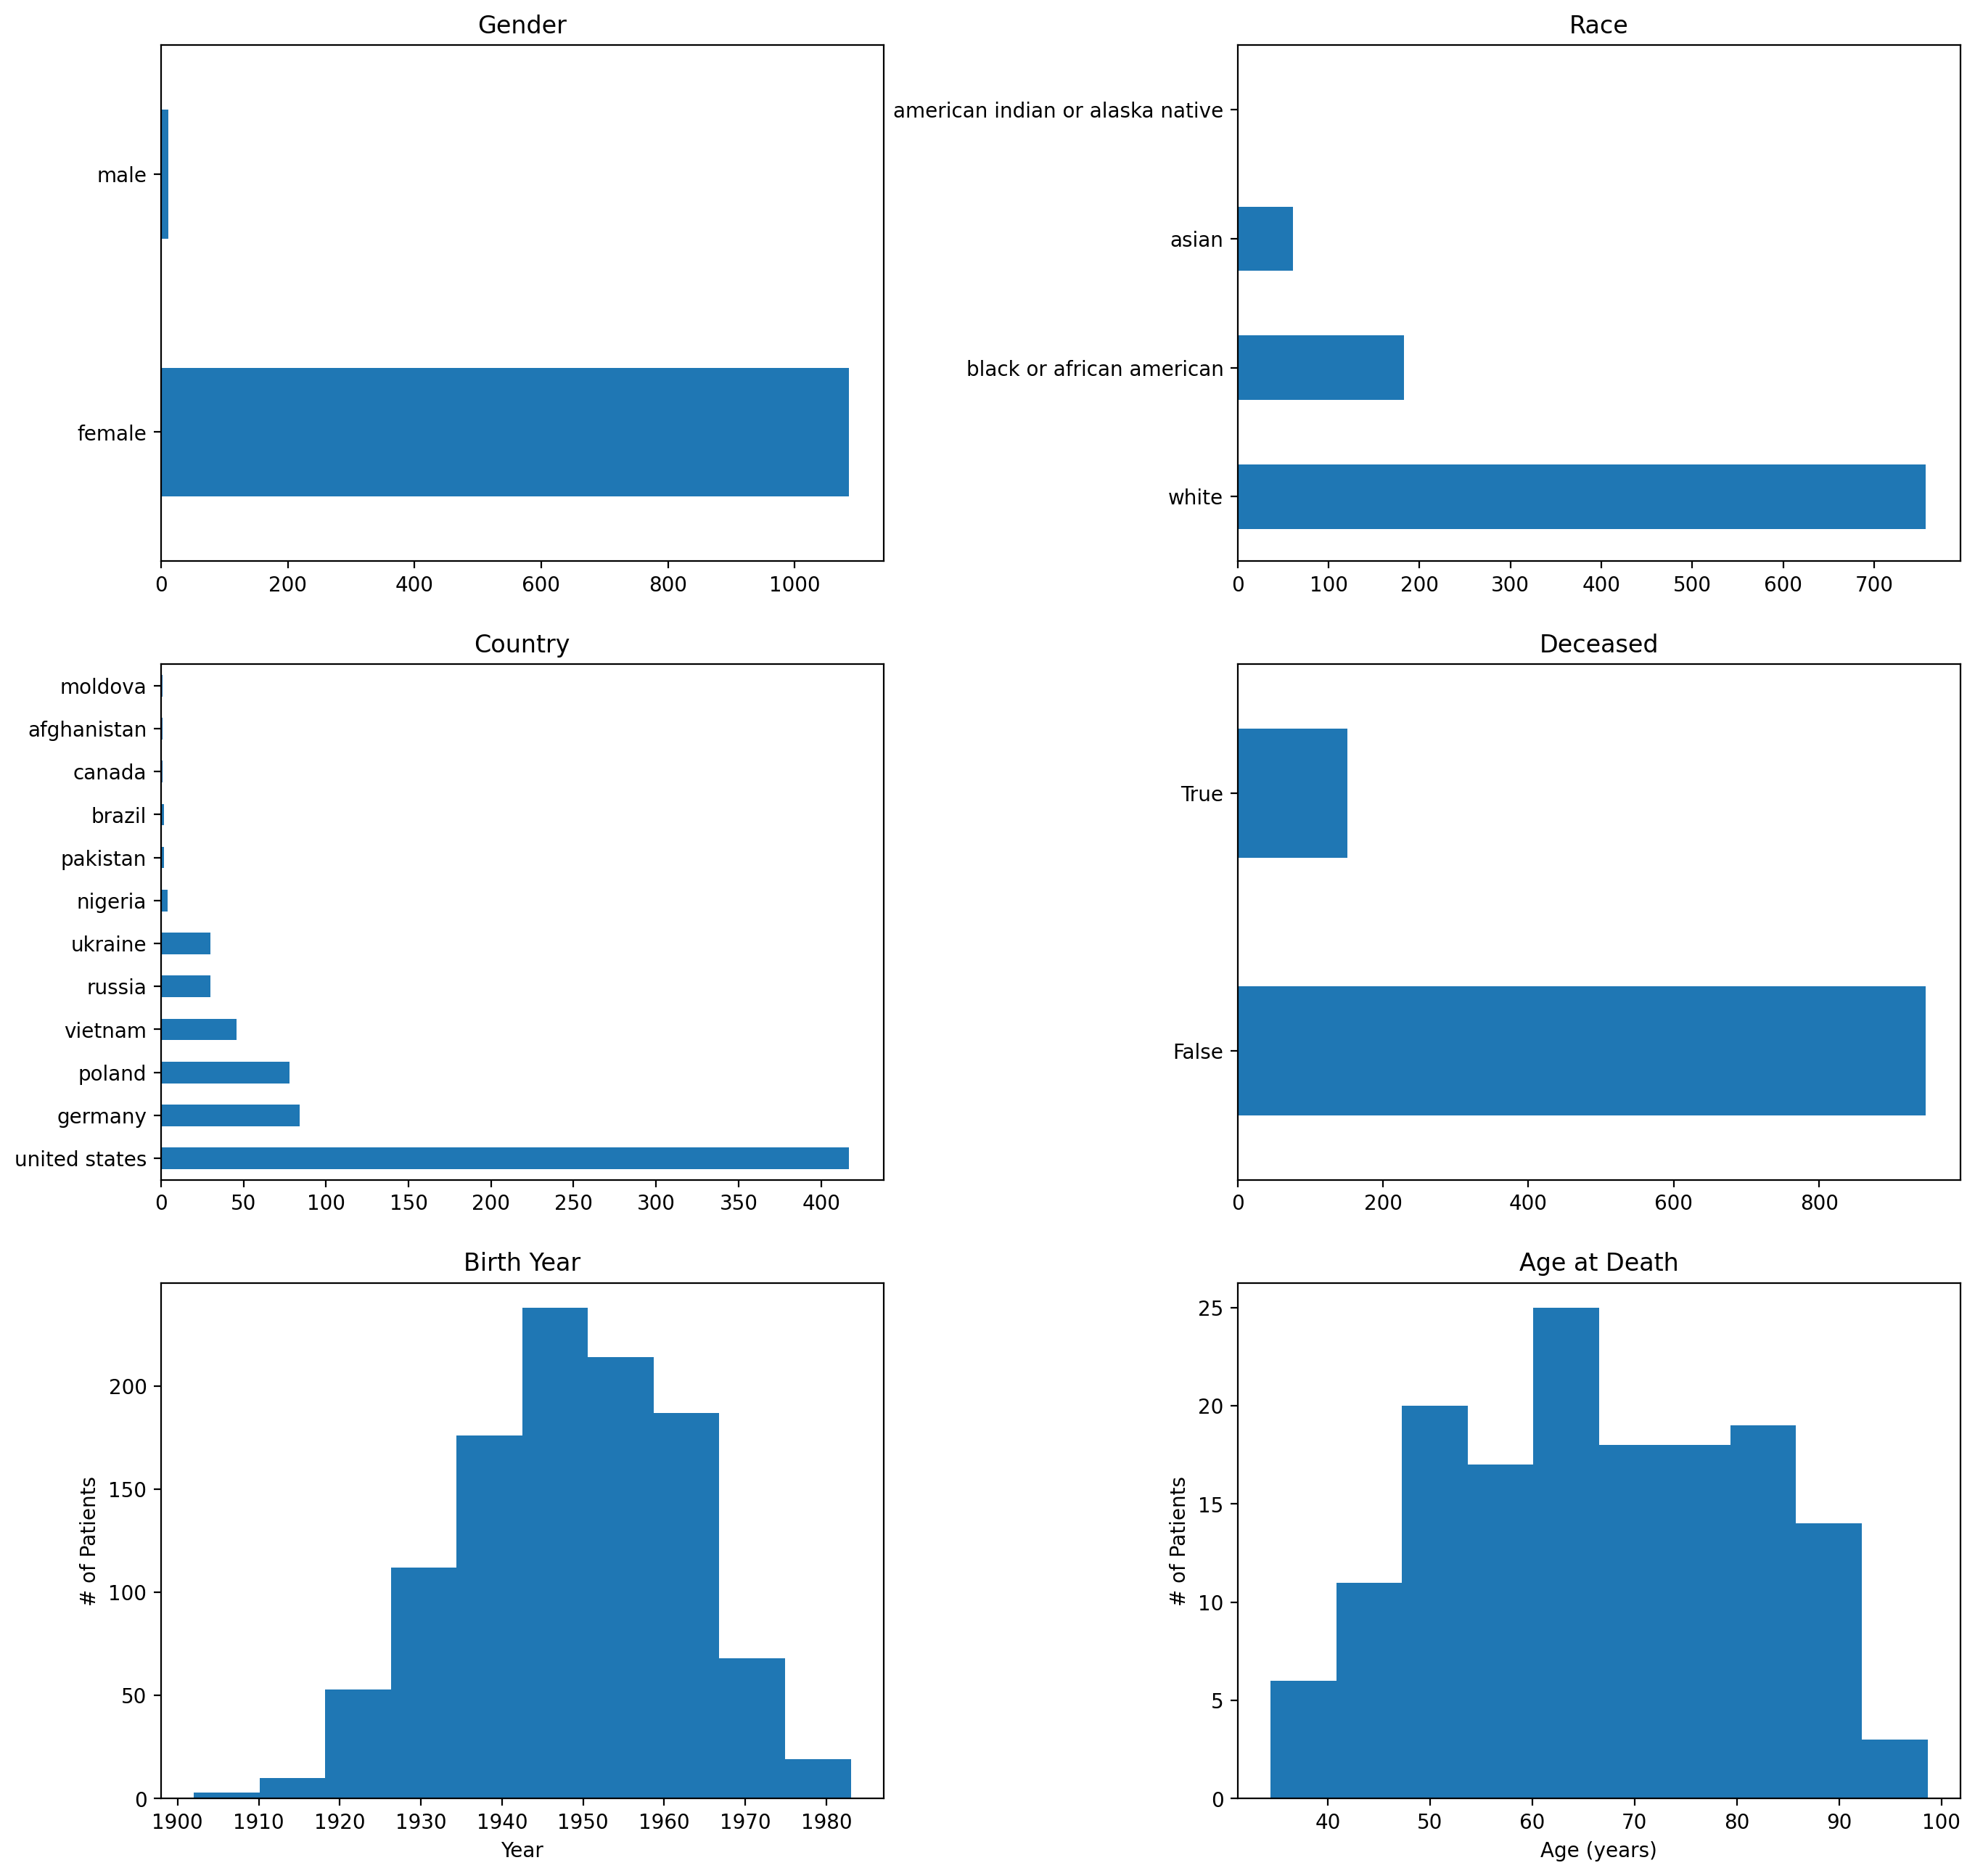

In [9]:
COLUMN_RACE = "extension.url__hl7.org/fhir/StructureDefinition/us-core-race__valueCodeableConcept_coding_system__hl7.org/fhir/v3/Race__display"

fig, axes = plt.subplots(
    nrows=3, ncols=2,
    figsize=(16, 16),
    dpi=200,
    gridspec_kw=dict(wspace=0.49)
)

# Plot gender counts
patient_df.gender.value_counts().plot.barh(
    ax=axes[0, 0],
    title="Gender"
)

# Plot race counts
patient_df[COLUMN_RACE].value_counts().plot.barh(
    ax=axes[0, 1],
    title="Race"
)

# Plot country counts
patient_df.address_country.value_counts().plot.barh(
    ax=axes[1, 0],
    title="Country"
)

# Plot deceased (by whether a deceased timestamp exists)
patient_df["deceasedDateTime.local"].apply(
    pd.notnull
).value_counts().plot.barh(
    ax=axes[1, 1],
    title="Deceased"
)

# Plot histogram of birth years
patient_df["birthDate.local"].dt.year.dropna().astype(int).plot.hist(
    ax=axes[2, 0],
    title="Birth Year",
)
axes[2, 0].set_xlabel("Year")
axes[2, 0].set_ylabel("# of Patients")

# Plot age at death
patient_df[
    # Filter by those who have passed away
    patient_df["deceasedDateTime.local"].notnull()
].pipe(
    # Calculate survival in years
    lambda df: (
        df["deceasedDateTime.local"] - df["birthDate.local"]
    ).dt.total_seconds() / (60 * 60 * 24 * 365.25)
).plot.hist(
    ax=axes[2, 1],
    title="Age at Death"
)
axes[2, 1].set_xlabel("Age (years)")
axes[2, 1].set_ylabel("# of Patients")

fig.show()